### 7-4 HHLアルゴリズムを用いたポートフォリオ最適化
この節では[1]を参考に、過去の株価変動のデータから、最適なポートフォリオ（資産配分）を計算する。
このようなポートフォリオ最適化の問題は、量子計算の基本的なアルゴリズムである「HHLアルゴリズム」を用いることで、従来より高速に解けることが期待されている。
本ノートブックでは、GAFA(Google, Apple, Facebook, Amazon)の4社の株に投資する際、どのような資産配分を行えば最も低いリスクで高いリターンを得られるかという問題を考える。

### 7-4-1 株価データ取得
* GAFA 4社の日次データを用いる
* 株価データ取得のためにpandas_datareaderを用いてYahoo! Financeのデータベースから取得
* 株価はドル建ての調整後終値（Adj. Close）を用いる

In [1]:
# データ取得に必要なpandas, pandas_datareaderのインストール
# !pip install pandas pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [3]:
# 銘柄選択
codes = ['GOOG', 'AAPL', 'FB', 'AMZN'] # GAFA

# 2017年の1年間のデータを使用
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df = data['Adj Close'] 

display(df.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,170.379120,1168.359985,177.199997,1060.119995
2017-12-26,166.056595,1176.760010,175.990005,1056.739990
2017-12-27,166.085815,1182.260010,177.619995,1049.369995
2017-12-28,166.553101,1186.099976,177.919998,1048.140015
2017-12-29,164.752060,1169.469971,176.460007,1046.400024


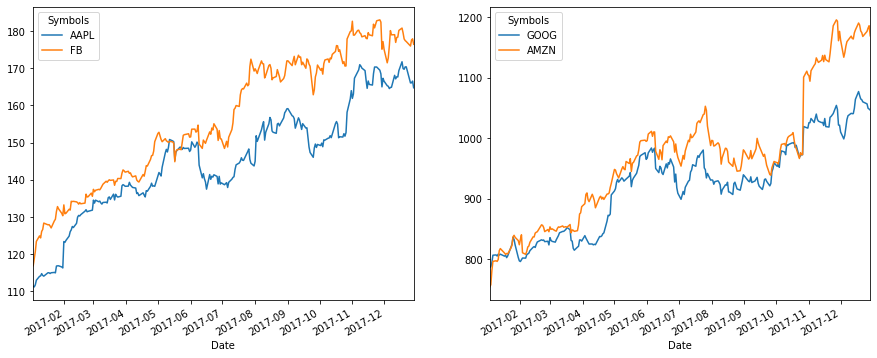

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

※ここで、4つの銘柄を2つのグループに分けているのは、株価の値がそれぞれ近くプロット時に見やすいからであり、深い意味はない。

### データ前処理
株価を日次リターンに
個別銘柄の日次リターン（変化率） $y_t$ （$t$は日付）は以下で定義される。 
$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$
これは `pandas DataFrame` の `pct_change()` メソッドで得られる。

In [5]:
daily_return = df.pct_change()
display(daily_return.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,0.000000,-0.005448,-0.001409,-0.003300
2017-12-26,-0.025370,0.007190,-0.006828,-0.003188
2017-12-27,0.000176,0.004674,0.009262,-0.006974
2017-12-28,0.002814,0.003248,0.001689,-0.001172
2017-12-29,-0.010814,-0.014021,-0.008206,-0.001660


### 期待リターン
銘柄ごとの期待リターン$\vec R$を求める。ここでは過去のリターンの算術平均を用いる： 
$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y(t)
$$

In [6]:
expected_return = daily_return.dropna(how='all').mean() * 252 # 年率換算のため年間の営業日数252を掛ける
expected_return

Symbols
AAPL    0.411192
AMZN    0.464567
FB      0.430156
GOOG    0.300215
dtype: float64

### 現在価格
各銘柄の現在価格 $\Pi$

In [7]:
current_price = df.iloc[-1].copy()
# current_price.iloc[:] = np.ones(4) # Π=1 のために必要
current_price

Symbols
AAPL     164.752060
AMZN    1169.469971
FB       176.460007
GOOG    1046.400024
Name: 2017-12-29 00:00:00, dtype: float64

In [8]:
df.tail()

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2017-12-22,170.379120,1168.359985,177.199997,1060.119995
2017-12-26,166.056595,1176.760010,175.990005,1056.739990
2017-12-27,166.085815,1182.260010,177.619995,1049.369995
2017-12-28,166.553101,1186.099976,177.919998,1048.140015
2017-12-29,164.752060,1169.469971,176.460007,1046.400024


### 分散・共分散行列
リターンの標本不偏分散・共分散行列$\Sigma$は以下で定義される。
$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y(t) -\vec R ) (\vec y(t) -\vec R )^T
$$

In [9]:
cov = daily_return.dropna(how='all').cov() * 252 # 年率換算のため
display(cov)

Symbols,AAPL,AMZN,FB,GOOG
Symbols,,,,
AAPL,0.031119,0.018877,0.016291,0.013303
AMZN,0.018877,0.044120,0.023337,0.021614
FB,0.016291,0.023337,0.028855,0.018382
GOOG,0.013303,0.021614,0.018382,0.023690


### 7-4-2 ポートフォリオ最適化
以下の式を満たすようなポートフォリオ（i.e., 資産配分）$\vec w$を求める。
$$
\begin{eqnarray}
\min_{\vec w} \vec w^T \Sigma \vec w \\
{\rm s.t. } \vec R^T \vec w = \mu \\ 
\vec \Pi^T \vec w =\xi
\end{eqnarray}
$$
ここで、3つの式はそれぞれ
* 「ポートフォリオのリターンの分散最小化」
* 「ポートフォリオの期待リターンが$\mu$となること」
* 「ポートフォリオに投資する金額の合計が$\xi$となること」

という条件を表す。
ラグランジュの未定乗数法を用いると、この条件を満たす$\vec w$は、線形方程式
$$
W\left ( 
\begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right )
=
\left ( 
\begin{array}{c}
 \mu \\
 \xi \\
\vec 0
\end{array}
\right ),\tag{1}
$$
$$ 
\\ W = \left ( 
\begin{array}{ccc} 0 & 0 & \vec R^T \\ 0 & 0 & \vec \Pi^T \\ \vec{R} &\vec \Pi & \Sigma 
\end{array} \right ) 
$$
を解くことで得られる事がわかる。ここで$\eta, \theta$はラグランジュの未定乗数法のパラメータ。 $\mu$はポートフォリオの期待リターン、$\xi$は総資産額である。
したがって、最適なポートフォリオ$\vec w$を求めるためには、連立方程式(1)を$\vec w$について解けば良い。

### 行列Wの作成

In [10]:
R = expected_return.values
Pi = current_price.values
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[0.00000000e+00 0.00000000e+00 4.11191576e-01 4.64567475e-01 4.30155633e-01 3.00214579e-01]
 [0.00000000e+00 0.00000000e+00 1.64752060e+02 1.16946997e+03 1.76460007e+02 1.04640002e+03]
 [4.11191576e-01 1.64752060e+02 3.11191462e-02 1.88766638e-02 1.62913410e-02 1.33033146e-02]
 [4.64567475e-01 1.16946997e+03 1.88766638e-02 4.41204912e-02 2.33374705e-02 2.16144018e-02]
 [4.30155633e-01 1.76460007e+02 1.62913410e-02 2.33374705e-02 2.88548168e-02 1.83817461e-02]
 [3.00214579e-01 1.04640002e+03 1.33033146e-02 2.16144018e-02 1.83817461e-02 2.36900286e-02]]


### その他のパラメータ
ポートフォリオの期待リターン$\mu$を指定すると、そのようなリターンをもたらす最もリスクの小さいポートフォリオを計算できる。$\mu$は自由に設定できる。一般に期待リターンが大きいほどリスクも大きくなるが、ここでは例として10%としておく。

$\xi$はポートフォリオに投資する合計金額である。ここでは1とおくが、単位は何でも良い。

In [11]:
mu = 0.1 # ポートフォリオのリターン（手で入れるパラメータ）
xi = 1.0 
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R))
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0. ]


以上で、連立方程式(1)を解く準備が整った。

### 7-4-3 最小分散ポートフォリオ算出
7章で学んだ HHL アルゴリズムを用いて、連立一次方程式(1)を解く。

先ずはその下準備として、
* ベクトル $\vec {x}$ が与えられた時に $\sum_i x_i |i \rangle$ を準備する量子回路を返す関数 `input_state_gate`
* 制御位相ゲートを返す関数 `CPhaseGate`
* 量子フーリエ変換を行うゲートを返す関数 `QFT_gate` 

を実装する。

In [12]:
# Qulacs のインストール
# !pip install qulacs

In [13]:
import numpy as np
from qulacs import QuantumCircuit, QuantumState, gate
from qulacs.gate import merge, Identity, H, SWAP

def input_state_gate(start_bit, end_bit, vec):
    """ 
    Making a quantum gate which transform |0> to \sum_i x[i]|i>m where x[i] is input vector.
    !!! this uses 2**n times 2**n matrix, so it is quite memory-cosuming.
    !!! this gate is not unitary (we assume that the input state is |0>)
    Args:
      int start_bit: first index of qubit which the gate applies 
      int end_bit:   last index of qubit which the gate applies
      np.ndarray vec:  input vector.
    Returns:
      qulacs.QuantumGate 
    """
    nbit = end_bit - start_bit + 1
    assert vec.size == 2**nbit
    mat_0tox = np.eye(vec.size, dtype=complex)
    mat_0tox[:,0] = vec
    return gate.DenseMatrix(np.arange(start_bit, end_bit+1), mat_0tox)

def CPhaseGate(target, control, angle):
    """ 
    Create controlled phase gate diag(1,e^{i*angle}) with controll. (Qulacs.gate is requried)
    Args:
      int target:  index of target qubit.
      int control:  index of control qubit.
      float64 angle: angle of phase gate.
    Returns:
      QuantumGateBase.DenseMatrix: diag(1, exp(i*angle)).
    """
    CPhaseGate = gate.DenseMatrix(target, np.array( [[1,0], [0,np.cos(angle)+1.j*np.sin(angle)]])  )
    CPhaseGate.add_control_qubit(control, 1)
    return CPhaseGate

def QFT_gate(start_bit, end_bit, Inverse = False):
    """ 
    Making a gate which performs quantum Fourier transfromation between start_bit to end_bit.
    (Definition below is the case when start_bit = 0 and end_bit=n-1)
    We associate an integer  j = j_{n-1}...j_0 to quantum state |j_{n-1}...j_0>.
    We define QFT as
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(2pi*i*(k/2^n)*j) |j>.
    then, |k_m > = 1/sqrt(2)*(|0> + exp(i*2pi*0.j_{n-1-m}...j_0)|1> )
    When Inverse=True,  the gate represents Inverse QFT,
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(-2pi*i*(k/2^n)*j) |j>.
    Args:
      int start_bit:  first index of qubits where we apply QFT.
      int end_bit:    last  index of qubits where we apply QFT.
      bool Inverse: When True, the gate perform inverse-QFT ( = QFT^{\dagger}).
    Returns:
      qulacs.QuantumGate: QFT gate which acts on a region between start_bit and end_bit.
    """

    gate = Identity(start_bit) ## make empty gate
    n = end_bit - start_bit + 1  ## size of QFT

    ## loop from j_{n-1} 
    for target in range(end_bit, start_bit-1, -1):
        gate = merge(gate, H(target)) ## 1/sqrt(2)(|0> + exp(i*2pi*0.j_{target})|1>)
        for control in range(start_bit, target):
            gate = merge( gate, CPhaseGate(target, control, (-1)**Inverse * 2.*np.pi/2**(target-control+1)) )
    ## perform SWAP between (start_bit + s)-th bit and (end_bit - s)-th bit
    for s in range(n//2):  ## s runs 0 to n//2-1
        gate = merge(gate, SWAP(start_bit + s, end_bit - s))
    ## return final circuit
    return gate

次に連立方程式 $A \vec{x} = \vec{b}$の $A$, $\vec{b}$ を入力として、HHL アルゴリズムを用いて解 $\vec{x}$ を求める関数 `HHL_solve` を実装する。

引数として上記 $A$、 $\vec{b}$ に加え、レジスタ量子ビット数 `reg_nbit`（デフォルト=`4`）、$U=e^{iAt}$ の位相推定に使う時間 $t$（デフォルト=`0.5`）を取る。

返り値は2つあり、それぞれ HHL アルゴリズムによる解 `x_HHL` と、通常の古典計算の対角化による解 `x_true` である。

In [14]:
from functools import reduce

def HHL_solve(A, b, reg_nbit=4, t=0.5):
    """
    連立一次方程式Ax=bを解く。
    Parameters
    ----------
    A : ndarray
        n×n行列。
    b : ndarray
        n次元ベクトル。
    reg_nbit : int
        計算に用いるレジスタ量子ビットの数。
    t : float
        U=e^{iAt} の位相推定に使う時間
    
    Returns
    -----------
    x_HHL : ndarray
        シミュレーターを用いたHHLアルゴリズムによる解x。
    x_true : ndarray
        np.linalg.solveによる解x。
    """

    assert len(A)==len(b), 'Dimension mismatch.'

    print('A.shape:', A.shape)
    print('b.shape:', b.shape)

    ### ---------  パラメータ設定始まり -------------- ###
    ## 乱数の初期化
    #my_seed = 301
    #np.random.seed(my_seed)

    ## 解きたい一次方程式 Ax=b の行列およびベクトルの大きさ
    n = len(b)

    # nbit = 2 ## bit数 (ベクトルの長さは2^nbit)
    nbit = np.int(np.ceil(np.log2(n))) # 考える行列の次元が2^n (n:整数)でない場合にも対応
    N = 2**nbit

    # A (b) をN×N行列A0 (N次元ベクトルb0) に入れておく。残りの部分は0で埋める。
    A0 = np.zeros((N, N))
    A0[:A.shape[0],:A.shape[1]] = A
    b0 = np.zeros(N)
    b0[:len(b)] = b

    ## U=e^{iAt} の位相推定に使う時間 t とレジスタbitの数
    # t = 0.5
    # reg_nbit = 4
    reg_N = 2**reg_nbit

    ## A*tの固有値として想定する最小の値 (論文(70)式).
    ## 今回は射影が100%成功するので, レジスタで表せる最小値の定数倍でとっておく
    C = 0.5*(2 * np.pi * (1. / 2**(reg_nbit) ))

    ## Ax=bを解く行為を何回繰り返すか
    trial_num = 1
    ### ---------  パラメータ設定終わり -------------- ###

    ## 真の解を求めておく
    x_true = np.linalg.solve(A, b)
    #np.allclose(np.dot(A, x_true), b) ## <- 解が正しいかの確認

    ## 対角化してしまう. AP = PD <-> A = P*D*P^dag 
    D_A, P = np.linalg.eigh(A0)


    ### ---------  以下, 計算コード  -------------- ###
    print("nbit, reg_nbit, t = {0}, {1}, {2}".format(nbit, reg_nbit,t) )

    #####################################
    ### HHL量子回路を作る. 0番目のビットから順に、Aの作用する空間のbit達 (0番目 ~ nbit-1番目), 
    ### register bit達 (nbit番目 ~ nbit+reg_nbit-1番目), conditional回転用のbit (nbit+reg_nbit番目)
    ### とする.
    #####################################
    total_qubits = nbit + reg_nbit + 1
    total_circuit = QuantumCircuit(total_qubits)

    ## ------ 0番目~(nbit-1)番目のbitに入力するベクトルbの準備 ------
    ## 本来はqRAMのアルゴリズム(論文Fig.4)を用いるが, ここでは自作の入力ゲートを用いている. 
    ## qulacsではstate.load(b)でも実装可能.
    state = QuantumState(total_qubits)
    state.set_zero_state() 
    b_gate = input_state_gate(0, nbit-1, b0)
    total_circuit.add_gate(b_gate)

    ## ------- レジスターbit に Hadamard gate をかける -------
    for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
        total_circuit.add_H_gate(register)

    ## ------- 位相推定を実装 -------
    ## U := e^{i*A*t), その固有値をdiag( {e^{i*2pi*phi_k}}_{k=0, ..., N-1) )とおく.
    ## Implement \sum_j |j><j| exp(i*A*t*j) to register bits
    for register in range(nbit, nbit+reg_nbit):
        ## U^{2^{register-nbit}} を実装.
        ## 対角化した結果を使ってしまう
        U_mat = reduce(np.dot,  [P, np.diag(np.exp( 1.j*D_A*t * (2**(register-nbit)) )), P.T.conj()]  )
        U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
        U_gate.add_control_qubit(register, 1) ## control bitの追加
        total_circuit.add_gate(U_gate)

    ## ------- Perfrom inverse QFT to register bits -------
    total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=True))

    ## ------- conditional rotation を掛ける -------
    ## レジスター |phi> に対応するA*tの固有値は l = 2pi * 0.phi = 2pi * (phi / 2**reg_nbit).
    ## conditional rotationの定義は
    ## |phi>|0> -> C/(lambda)|phi>|0> + sqrt(1 - C^2/(lambda)^2)|phi>|1>.
    ## 古典シミュレーションなのでゲートをあらわに作ってしまう.
    condrot_mat = np.zeros( (2**(reg_nbit+1), (2**(reg_nbit+1))), dtype=complex)
    for index in range(2**reg_nbit):
        lam = 2 * np.pi * (float(index) / 2**(reg_nbit) )
        index_0 = index ## integer which represents |index>|0>
        index_1 = index + 2**reg_nbit ## integer which represents |index>|1>
        if lam >= C:
            condrot_mat[index_0, index_0] = C / lam 
            condrot_mat[index_1, index_0] =   np.sqrt( 1 - C*C/lam/lam)
            condrot_mat[index_0, index_1] = - np.sqrt( 1 - C*C/lam/lam)
            condrot_mat[index_1, index_1] = C / lam
        else:
            condrot_mat[index_0, index_0] = 1.
            condrot_mat[index_1, index_1] = 1.
    ## DenseGateに変換して実装
    condrot_gate = gate.DenseMatrix(np.arange(nbit, nbit+reg_nbit+1), condrot_mat) 
    total_circuit.add_gate(condrot_gate)

    ## ------- Perfrom QFT to register bits -------
    total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=False))

    ## ------- 位相推定の逆を実装(U^\dagger = e^{-iAt}) -------
    for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
        ## {U^{\dagger}}^{2^{register-nbit}} を実装.
        ## 対角化した結果を使ってしまう
        U_mat = reduce(np.dot,  [P, np.diag(np.exp( -1.j*D_A*t * (2**(register-nbit)) )), P.T.conj()]  )
        U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
        U_gate.add_control_qubit(register, 1) ## control bitの追加
        total_circuit.add_gate(U_gate)

    ## ------- レジスターbit に Hadamard gate をかける -------
    for register in range(nbit, nbit+reg_nbit): 
        total_circuit.add_H_gate(register)

    ## ------- 補助ビットを0に射影する(古典シミュレーションなので確率100%で可能) -------
    total_circuit.add_P0_gate(nbit+reg_nbit)

    #####################################
    ### HHL量子回路を実行し, 結果を取り出す
    #####################################
    total_circuit.update_quantum_state(state)
    ## 0番目から(nbit-1)番目の bit が計算結果 |x>に対応
    result = state.get_vector()[:2**nbit].real
    x_HHL = result*t/C

    x_HHL = x_HHL[:n] # 不要な部分の切り取り

    return x_HHL, x_true

In [15]:
x_HHL, x_true = HHL_solve(W, mu_xi_0, reg_nbit=8, t=0.5)

A.shape: (6, 6)
b.shape: (6,)
nbit, reg_nbit, t = 3, 8, 0.5


In [16]:
w_opt_HHL = x_HHL[-len(R):] # xから、wのみを取り出す（η, θは不要）
w_opt_true = x_true[-len(R):] # （同上）
w_opt = pd.DataFrame(np.vstack([w_opt_true, w_opt_HHL]).T, index=df.columns, columns=['True', 'HHL'])
w_opt

,True,HHL
Symbols,,
AAPL,0.100921,0.052406
AMZN,0.025295,0.048317
FB,0.157357,0.078080
GOOG,-0.069740,0.004235


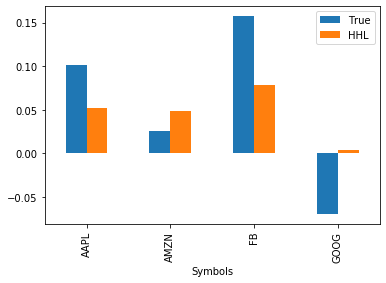

In [17]:
w_opt.plot.bar()

※重みが負になっている銘柄は、「空売り」（株を借りてきて売ること。株価が下がる局面で利益が得られる手法）を表す。
HHLは近似アルゴリズムであるため、古典計算による厳密解と多少乖離がある。
レジスタ量子ビット数 `reg_nbit` といったパラメータを変化させる等、色々試してみて頂きたい。

### Appendix: バックテスト
過去のデータから得られた投資ルールを、それ以降のデータを用いて検証することを「バックテスト」と呼び、その投資ルールの有効性を測るために重要である。
ここでは以上のように2017年のデータから構築したポートフォリオに投資した場合に、翌年の2018年にどの程度資産価値が変化するかを観察する。

In [18]:
# 2018年の1年間のデータを使用
start = datetime.datetime(2017, 12, 30)
end = datetime.datetime(2018, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df2018 = data['Adj Close'] 

display(df2018.tail())

Symbols,AAPL,AMZN,FB,GOOG
Date,,,,
2018-12-24,145.090836,1343.959961,124.059998,976.219971
2018-12-26,155.308350,1470.900024,134.179993,1039.459961
2018-12-27,154.300446,1461.640015,134.520004,1043.880005
2018-12-28,154.379486,1478.020020,133.199997,1037.079956
2018-12-31,155.871613,1501.969971,131.089996,1035.609985


In [19]:
# ポートフォリオの資産価値の推移
pf_value = df2018.dot(w_opt)
pf_value.head()

,True,HHL
Date,,
2017-12-29,1.000000,83.348988
2018-01-02,1.275292,84.913743
2018-01-03,0.948930,85.973933
2018-01-04,0.836988,86.265234
2018-01-05,0.817619,87.574147


In [20]:
pf_value.HHL = pf_value.HHL / pf_value.HHL[0] # HHLはあくまで近似解で、規格化条件を満たさない場合があるため、期初の値で規格化。
pf_value.head()

,True,HHL
Date,,
2017-12-29,1.000000,1.000000
2018-01-02,1.275292,1.018774
2018-01-03,0.948930,1.031493
2018-01-04,0.836988,1.034988
2018-01-05,0.817619,1.050692


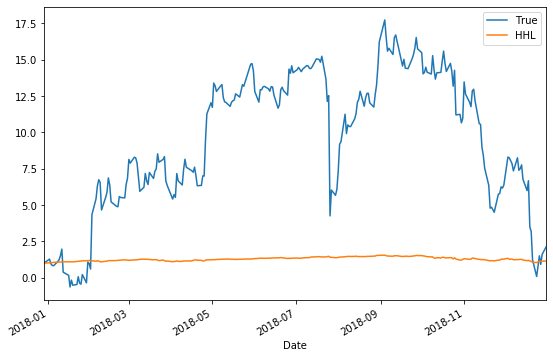

In [21]:
pf_value.plot(figsize=(9, 6))

## 参考文献
[1] Quantum computational finance: quantum algorithm for portfolio optimization, P. Rebentrost, S. Lloyd, (preprint) https://arxiv.org/abs/1811.03975